# PID Graph Key Performance Indicators (KPIs)

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch summary statistics about nodes and connections.


**Goal**: By then end of this notebook you should be able to visualize the PID Graph summary statistics in different ways. We would retrieve the data from the PID Graph, we will transform it and then will create a visulisation to make sense of it.



In [35]:
# Prepare the R graphql client.

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("RColorBrewer")
#install.packages("Hmisc")

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")
library("RColorBrewer")

library("Hmisc")


cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

### Define the Data we want to obtain

The first step is to define what data we want. For this example we will extract the PID Graph summary statistics. 

We obtain this data using the Graphql query language. A Graphql query looks like a JSON snippet. 

In this examples we will just request all the fields related to sholarly items and their connections.

In [36]:
query <- '{
  publications {
    totalCount
    publicationConnectionCount
    datasetConnectionCount
    softwareConnectionCount
    personConnectionCount
    organizationConnectionCount
    funderConnectionCount
  }
  datasets {
    totalCount
    datasetConnectionCount
    softwareConnectionCount
    personConnectionCount
    organizationConnectionCount
    funderConnectionCount
  }
  softwareSourceCodes {
    totalCount
    softwareConnectionCount
    personConnectionCount
    organizationConnectionCount
    funderConnectionCount
  }
  people {
    totalCount
    organizationConnectionCount
  }
  organizations {
    totalCount
  }

  funders {
    totalCount
  }
}'

### Run the query and parse the JSON response


Once we make the query we will obtain a response that looks like a nested list. 


In [37]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))
list.tree(data)

### Transform data for visualisation.

We need to transform the nested list into some consumable for visulisations. In this case we will transform it into a flat list of Nodes and Connections/Edges. 


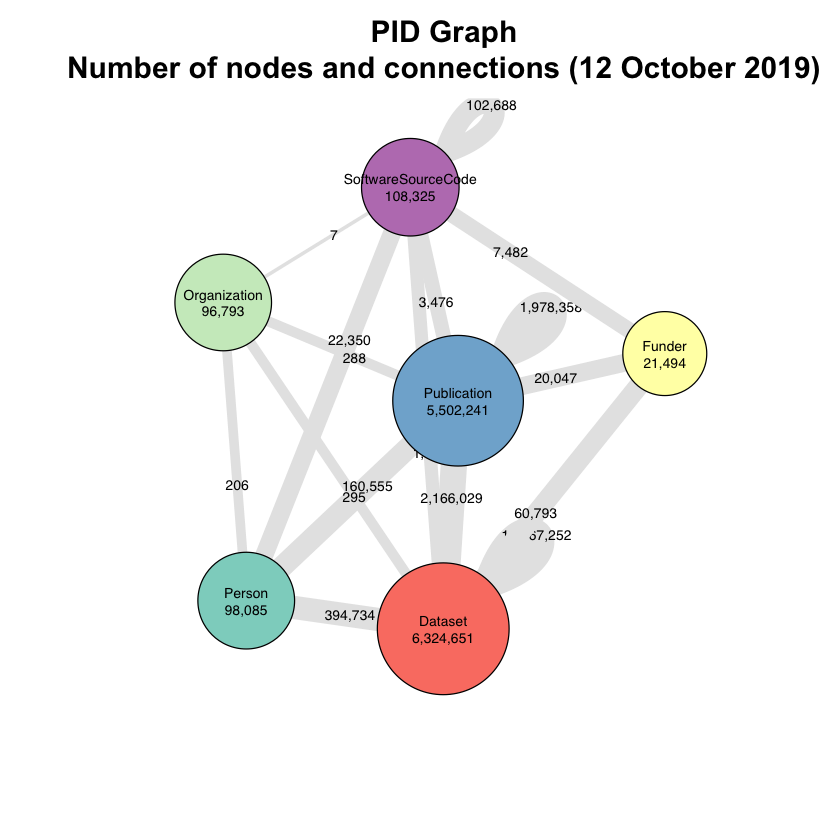

In [56]:
# generate data frame for nodes
publications <- data.frame(id=c('Publication'), count=data$data$publications$totalCount)
datasets <- data.frame(id=c('Dataset'), count=data$data$datasets$totalCount)
softwareSourceCodes <- data.frame(id=c('SoftwareSourceCode'), count=data$data$softwareSourceCodes$totalCount)
people <- data.frame(id=c('Person'), count=data$data$people$totalCount)
organizations <- data.frame(id=c('Organization'), count=data$data$organizations$totalCount)
funders <- data.frame(id=c('Funder'), count=data$data$funders$totalCount)
nodes <- rbind(publications, datasets, softwareSourceCodes, people, organizations, funders)

edges <- data.frame(to=character(), from=character())
edges <- rbind(edges, data.frame(from="Publication", to="Publication", count=data$data$publications$publicationConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Dataset", count=data$data$publications$datasetConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="SoftwareSourceCode", count=data$data$publications$softwareConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Person", count=data$data$publications$personConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Organization", count=data$data$publications$organizationConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Funder", count=data$data$publications$funderConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Dataset", count=data$data$datasets$datasetConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="SoftwareSourceCode", count=data$data$datasets$softwareConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Person", count=data$data$datasets$personConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Funder", count=data$data$datasets$funderConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Organization", count=data$data$datasets$organizationConnectionCount))
edges <- rbind(edges, data.frame(from="SoftwareSourceCode", to="SoftwareSourceCode", count=data$data$softwareSourceCodes$softwareConnectionCount))
edges <- rbind(edges, data.frame(from="SoftwareSourceCode", to="Person", count=data$data$softwareSourceCodes$personConnectionCount))
edges <- rbind(edges, data.frame(from="SoftwareSourceCode", to="Organization", count=data$data$softwareSourceCodes$organizationConnectionCount))
edges <- rbind(edges, data.frame(from="SoftwareSourceCode", to="Funder", count=data$data$softwareSourceCodes$funderConnectionCount))
edges <- rbind(edges, data.frame(from="Person", to="Organization", count=data$data$people$organizationConnectionCount))

# to fix "Some vertex names in edge list are not listed in vertex data frame"
#edges[which(! edges$from %in% nodes$id) ,]
#edges[which(! edges$to %in% nodes$id) ,]

head(edges)
head(nodes)

### Generate the graph

The igraph library provides versatile options for descriptive network analysis and visualization.
To generate the graph we take the nodes and edges we generated and plot them together. 


In [ ]:

# generate graph
g <- graph_from_data_frame(edges, vertices=nodes)

# add node colors
cols <- brewer.pal(12, "Set3")
V(g)[(V(g)$name=="Publication")]$color<-cols[5]
V(g)[(V(g)$name=="Person")]$color<-cols[1]
V(g)[(V(g)$name=="Dataset")]$color<-cols[4]
V(g)[(V(g)$name=="SoftwareSourceCode")]$color<-cols[10]
V(g)[(V(g)$name=="Organization")]$color<-cols[11]
V(g)[(V(g)$name=="Funder")]$color<-cols[2]

# add labels
V(g)$label=paste(nodes$id, format(V(g)$count, big.mark=",", trim=TRUE), sep="\n")
E(g)$label <- format(E(g)$count, big.mark=",", trim=TRUE)

# calculate node size and edge width
V(g)$size <- log(V(g)$count, 1.3)
E(g)$width <- log(E(g)$count, 2)

E(g)$arrow.mode <- 0
l <- layout_nicely(g)
plot(g, layout=l, arrow.mode=0, vertex.label.color=c("black"), vertex.label.family="Helvetica", vertex.label.cex=c(0.7), edge.color=c("gray90"), edge.label.color=c("black"), edge.label.family="Helvetica", edge.label.cex=c(0.7), edge.loop.angle=-pi/4)
title(paste("PID Graph\nNumber of nodes and connections",
format(Sys.Date(), "(%d %B %Y)"), sep=" "),cex.main=1.5)